In [1]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz

%autoreload 2

In [2]:
import numpy as np
import os
import cProfile, pstats
from flatland.core.grid.grid4_astar import a_star


# In Flatland you can use custom observation builders and predicitors
# Observation builders generate the observation needed by the controller
# Preditctors can be used to do short time prediction which can help in avoiding conflicts in the network
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.line_generators import sparse_line_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

import matplotlib.pyplot as plt

In [3]:
width = 180  # With of map
height = 90  # Height of map
nr_trains = 2  # Number of trains that have an assigned task in the env
cities_in_map = 7# Number of cities where agents can start or end
seed = 50  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

In [4]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rail_pairs_in_city=max_rail_in_cities//2,
                                       )

In [5]:
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

In [6]:
line_generator = sparse_line_generator(speed_ration_map)

stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

observation_builder = GlobalObsForRailEnv()

from flatland.envs.malfunction_generators import Malfunction

class NoMalfunctionGenerator:
    def generate(self, np_random):
        return Malfunction(0)

class AlwaysThreeStepMalfunction:
    def generate(self, np_random):
        return Malfunction(3)

def test_waiting_no_transition():
    env = get_small_two_agent_env()
    env.malfunction_generator = NoMalfunctionGenerator()


In [10]:
env = RailEnv(width=width,
              height=height,
              rail_generator=rail_generator,
              line_generator=line_generator,
              number_of_agents=nr_trains,
              obs_builder_object=observation_builder,
              #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              malfunction_generator=ParamMalfunctionGen(stochastic_data),
              remove_agents_at_target=True,
              random_seed=seed)
profiler = cProfile.Profile()
profiler.enable() 
env.reset(random_seed= seed);
profiler.disable()
stats = pstats.Stats(profiler)
%snakeviz env.reset(random_seed=seed)

 
*** Profile stats marshalled to file 'C:\\Users\\robin\\AppData\\Local\\Temp\\tmpyqeee_fp'.
Embedding SnakeViz in this document...
<function display at 0x000001585717AA20>


In [14]:
%lprun -f a_star env.reset(random_seed=seed)

Timer unit: 1e-07 s

Total time: 2.42027 s
File: C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\core\grid\grid4_astar.py
Function: a_star at line 50

Line #      Hits         Time  Per Hit   % Time  Line Contents
    50                                           def a_star(grid_map: GridTransitionMap, start: IntVector2D, end: IntVector2D,
    51                                                      a_star_distance_function: IntVector2DDistance = Vec2d.get_manhattan_distance, avoid_rails=False,
    52                                                      respect_transition_validity=True, forbidden_cells: IntVector2DArray = None) -> IntVector2DArray:
    53                                               """
    54                                           
    55                                               :param avoid_rails:
    56                                               :param grid_map: Grid Map where the path is found in
    57                             

In [11]:
%lprun?

Docstring:
Execute a statement under the line-by-line profiler from the
line_profiler module.

Usage:

    %lprun -f func1 -f func2 <statement>

The given statement (which doesn't require quote marks) is run via the
LineProfiler. Profiling is enabled for the functions specified by the -f
options. The statistics will be shown side-by-side with the code through the
pager once the statement has completed.

Options:

-f <function>: LineProfiler only profiles functions and methods it is told
to profile.  This option tells the profiler about these functions. Multiple
-f options may be used. The argument may be any expression that gives
a Python function or method object. However, one must be careful to avoid
spaces that may confuse the option parser.

-m <module>: Get all the functions/methods in a module

One or more -f or -m options are required to get any useful results.

-D <filename>: dump the raw statistics out to a pickle file on disk. The
usual extension for this is ".lprof". These s

In [11]:
env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=1020,  # Adjust these parameters to fit your resolution
                          screen_width=1800)

env.malfunction_generator = NoMalfunctionGenerator()

In [12]:
def show_env(env_renderer):
    env_renderer.render_env(show=False,  # whether to call matplotlib show() or equivalent after completion
                                show_agents=True,  # whether to include agents
                                show_inactive_agents=False,  # whether to show agents before they start
                                show_observations=True,  # whether to include observations
                                show_predictions=True,  # whether to include predictions
                                show_rowcols=True,  # label the rows and columns
                                frames=True,  # frame counter to show (intended since invocation)
                                episode=None,  # int episode number to show
                                step=None,  # int step number to show in image
                                selected_agent=None)  # indicate which agent is "selected" in the editor):
    plt.imshow(env_renderer.get_image())

In [36]:
from flatland.core.grid.grid_utils import IntVector2D
from flatland.core.grid.rail_env_grid import RailEnvTransitions
from flatland.core.transition_map import GridTransitionMap
import time
import random as rd

rail_trans = RailEnvTransitions()
grid_map = GridTransitionMap(width=width, height=height, transitions=rail_trans)
time1 = time.time()
for i in range(25):
    start = tuple((np.random.randint(low=0,high=width-1), np.random.randint(low=0, high=height-1)))
    end = tuple((np.random.randint(low=0, high=width-1), np.random.randint(low=0,high=height-1)))     
    a_star(grid_map=grid_map,start = start, end = end)
time2 = time.time()
print(time2-time1)

3.887777805328369


In [37]:
print("Initial positions",  [a.initial_position for a in env.agents])
print("Initial directions", [a.initial_direction for a in env.agents])
print("Earliest Departures", [a.earliest_departure for a in env.agents])
print("Targets", [a.target for a in env.agents])
print("Speed Counter values", [a.speed_counter.max_count for a in env.agents])

Initial positions [(70, 170), (62, 152)]
Initial directions [3, 0]
Earliest Departures [2037, 15]
Targets [(62, 153), (71, 170)]
Speed Counter values [1, 2]


In [10]:
def show_agents(env):
    for agent in env.agents:
        print(agent.handle, "Position", agent.position, "State", agent.state, end='\t')
    print()

In [11]:
for _ in range(max(a.earliest_departure for a in env.agents)+ 1):
    env.step({0: RailEnvActions.DO_NOTHING, 1: RailEnvActions.DO_NOTHING})
show_agents(env)

0 Position None State 1	1 Position None State 1	


0 Position (70, 170) State 3	1 Position (62, 152) State 3	
0 Position (70, 170) State 3	1 Position (62, 152) State 3	
0 Position (70, 169) State 3	1 Position (62, 152) State 3	
0 Position (70, 169) State 3	1 Position (61, 152) State 3	
0 Position (70, 168) State 3	1 Position (61, 152) State 3	
0 Position (70, 168) State 3	1 Position (61, 152) State 3	
0 Position (70, 167) State 3	1 Position (60, 152) State 3	
0 Position (70, 167) State 3	1 Position (60, 152) State 3	
0 Position (70, 166) State 3	1 Position (60, 152) State 3	


C:\Users\Robin\anaconda3\Lib\site-packages\flatland\utils\rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(
C:\Users\Robin\anaconda3\Lib\site-packages\flatland\utils\rendertools.py:418: UserWarning: Predictor did not provide any predicted cells to render.                 Predictors builder needs to populate: env.dev_pred_dict
  warnings.warn(


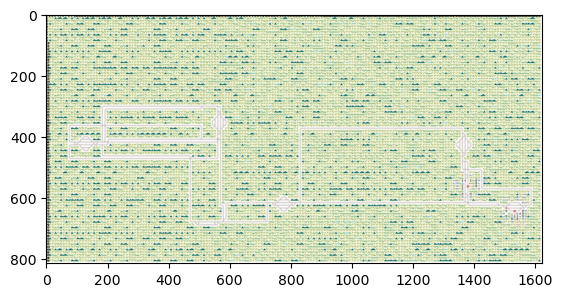

In [12]:
for _ in range(9):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.MOVE_FORWARD
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

0 Position (70, 166) State 3	1 Position (60, 152) State 3	


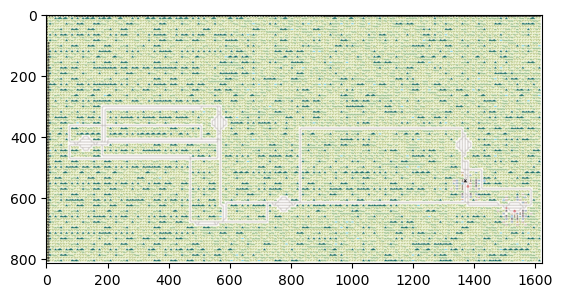

In [136]:
env.agents[1].malfunction_handler._set_malfunction_down_counter(100)
show_agents(env)
show_env(env_renderer)

0 Position (70, 166) State 3	1 Position (60, 152) State 5	
0 Position (69, 166) State 3	1 Position (60, 152) State 5	


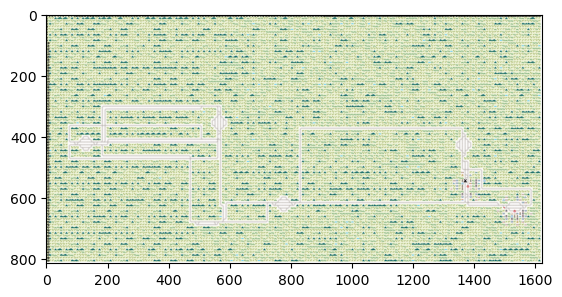

In [137]:
for _ in range(2):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.STOP_MOVING
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

In [14]:
show_agents(env)

0 Position (7, 17) State TrainState.MOVING	1 Position (7, 25) State TrainState.MALFUNCTION	


0 Position (7, 18) State TrainState.MOVING	1 Position (7, 25) State TrainState.MALFUNCTION	


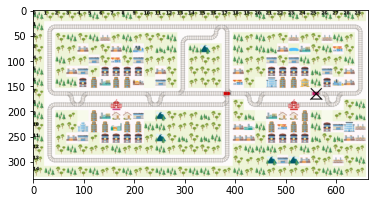

In [15]:
action_dict = {}
action_dict[0] = RailEnvActions.MOVE_FORWARD
action_dict[1] = RailEnvActions.STOP_MOVING
env.step(action_dict);
show_agents(env)
show_env(env_renderer)

In [16]:
import numpy as np
import os

from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.schedule_generators import sparse_schedule_generator


def get_small_two_agent_env():
    """Generates a simple 2 city 2 train env returns it after reset"""
    width = 30  # With of map
    height = 15  # Height of map
    nr_trains = 2  # Number of trains that have an assigned task in the env
    cities_in_map = 2 # Number of cities where agents can start or end
    seed = 42  # Random seed
    grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
    max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
    max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

    rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                        seed=seed,
                                        grid_mode=grid_distribution_of_cities,
                                        max_rails_between_cities=max_rails_between_cities,
                                        max_rail_pairs_in_city=max_rail_in_cities//2,
                                        )
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

    schedule_generator = sparse_schedule_generator(speed_ration_map)


    stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

    observation_builder = GlobalObsForRailEnv()

    env = RailEnv(width=width,
                height=height,
                rail_generator=rail_generator,
                schedule_generator=schedule_generator,
                number_of_agents=nr_trains,
                obs_builder_object=observation_builder,
                #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
                malfunction_generator=ParamMalfunctionGen(stochastic_data),
                remove_agents_at_target=True,
                random_seed=seed)

    env.reset()

    return env

ImportError:  Schedule Generators is now renamed to line_generators, any reference to schedule should be replaced with line

0 Position None State TrainState.WAITING	1 Position None State TrainState.READY_TO_DEPART	


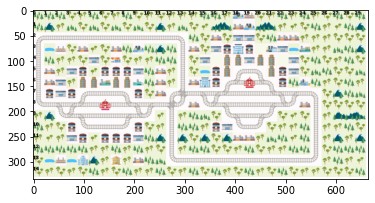

In [ ]:
env = get_small_two_agent_env()

env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=600,  # Adjust these parameters to fit your resolution
                          screen_width=800)

i_agent = 1
ed = env.agents[i_agent].earliest_departure
for _ in range(ed):
    env.step({i_agent: RailEnvActions.DO_NOTHING})

show_agents(env)
show_env(env_renderer)

0 Position None State TrainState.READY_TO_DEPART	1 Position (8, 7) State TrainState.MOVING	


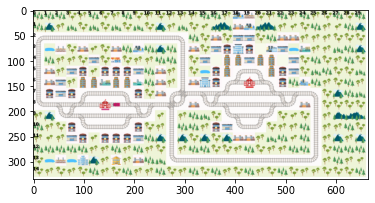

In [ ]:
for _ in range(50):
    env.step({i_agent: RailEnvActions.MOVE_FORWARD})

show_agents(env)
show_env(env_renderer)

0 Position None State TrainState.READY_TO_DEPART	1 Position (8, 7) State TrainState.MOVING	


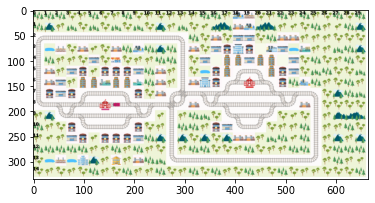

In [ ]:
show_agents(env)
show_env(env_renderer)
